<a href="https://www.kaggle.com/code/gpreda/neural-collaborative-filtering?scriptVersionId=129028024" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

Neural Collaborative Filtering (NCF) - a deep MF model that uses a neural network to model the interactions between users and items. NCF can be trained using stochastic gradient descent and has been shown to outperform traditional MF methods like SVD and NMF.

Source: Factorization Machine models in PyTorch (https://github.com/rixwew/pytorch-fm)


In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, mean_squared_error

In [2]:
from movie_lens_data import MovieLensData
from pt_layer import FeaturesEmbedding, MultiLayerPerceptron

# Read the data

In [3]:
path = "/kaggle/input/movielens-100k-dataset/ml-100k"
movie_lens_data = MovieLensData(
    users_path = os.path.join(path, "u.user"),
    ratings_path = os.path.join(path, "u.data"), 
    movies_path = os.path.join(path, "u.item"), 
    genre_path = os.path.join(path, "u.genre") 
    )

evaluation_data = movie_lens_data.read_ratings_data()
movie_data = movie_lens_data.read_movies_data()
popularity_rankings = movie_lens_data.get_popularity_ranks()
ratings = movie_lens_data.get_ratings()

# Prepare the dataset

In [4]:
class MovieLensDataset(torch.utils.data.Dataset):
    """
    MovieLens Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    """
    def __init__(self, ratings):
        data = ratings.copy().to_numpy()
        self.items = data[:, :2].astype(np.int32) - 1  # -1 because ID begins from 1
        self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.int64)
        self.item_field_idx = np.array((1,), dtype=np.int64)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target = target / 5.
        return target

In [5]:
def get_dataset():
    return MovieLensDataset(ratings)

# Prepare the algorithm

## The model

In [6]:
class NeuralCollaborativeFiltering(torch.nn.Module):
    """
    A pytorch implementation of Neural Collaborative Filtering.
    Reference:
        X He, et al. Neural Collaborative Filtering, 2017.
    """

    def __init__(self, field_dims, user_field_idx, item_field_idx, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.user_field_idx = user_field_idx
        self.item_field_idx = item_field_idx
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout, output_layer=False)
        self.fc = torch.nn.Linear(mlp_dims[-1] + embed_dim, 1)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_user_fields)``
        """
        x = self.embedding(x)
        user_x = x[:, self.user_field_idx].squeeze(1)
        item_x = x[:, self.item_field_idx].squeeze(1)
        x = self.mlp(x.view(-1, self.embed_output_dim))
        gmf = user_x * item_x
        x = torch.cat([gmf, x], dim=1)
        x = self.fc(x).squeeze(1)
        return torch.sigmoid(x)

## Early stopper

In [7]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_accuracy = 0
        self.save_path = save_path

    def is_continuable(self, model, accuracy):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.trial_counter = 0
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False

In [8]:
def get_model(dataset):
    field_dims = dataset.field_dims
    return NeuralCollaborativeFiltering(field_dims, embed_dim=64, mlp_dims=(32, 32), dropout=0.2,
                                       user_field_idx=dataset.user_field_idx,
                                       item_field_idx=dataset.item_field_idx) 

## Train

In [9]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    av_loss = []
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            loss = total_loss / log_interval
            av_loss.append(loss)
            tk0.set_postfix(loss=loss)
            total_loss = 0
    return np.mean(av_loss)

## Test/validation

In [10]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return 5.* mean_squared_error(targets, predicts)            

## Settings

In [11]:
device_cpu = "cpu"
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 64
epochs = 10
model_name = "ncf"
device = torch.device(device_cpu)

# Prepare train, valid & test datasets

In [12]:
dataset = get_dataset()
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

## Fit the model

In [13]:
model = get_model(dataset).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopper = EarlyStopper(num_trials=5, save_path=f'{model_name}.pt')

In [14]:
metric_values = []
loss_values = []

for epoch_i in range(epochs):

    loss = train(model, optimizer, train_data_loader, criterion, device)
    loss_values.append((epoch_i, loss))
    metric_valid = test(model, valid_data_loader, device)
    print('epoch:', epoch_i + 1, 'validation: mae:', metric_valid)
    
    metric_train = test(model, train_data_loader, device)
    print('train mae:', metric_train)
    
    metric_test = test(model, test_data_loader, device)
    print(f'test mae: {metric_test}')
    
    metric_values.append((epoch_i, metric_train, metric_valid, metric_test))

100%|██████████| 157/157 [00:00<00:00, 267.35it/s]


epoch: 1 validation: mae: 0.18669678765567768


100%|██████████| 1250/1250 [00:03<00:00, 314.14it/s]


train mae: 0.1732981616322477


100%|██████████| 157/157 [00:00<00:00, 267.22it/s]


test mae: 0.18377958543888895


100%|██████████| 157/157 [00:00<00:00, 282.45it/s]


epoch: 2 validation: mae: 0.18325727412616516


100%|██████████| 1250/1250 [00:04<00:00, 303.32it/s]


train mae: 0.16776849306151215


100%|██████████| 157/157 [00:00<00:00, 243.72it/s]


test mae: 0.18069499953338958


100%|██████████| 157/157 [00:00<00:00, 262.03it/s]


epoch: 3 validation: mae: 0.18125390411940767


100%|██████████| 1250/1250 [00:04<00:00, 309.53it/s]


train mae: 0.16340596914246341


100%|██████████| 157/157 [00:00<00:00, 239.07it/s]


test mae: 0.17737422065492314


100%|██████████| 157/157 [00:00<00:00, 254.56it/s]


epoch: 4 validation: mae: 0.1795522189316237


100%|██████████| 1250/1250 [00:04<00:00, 312.30it/s]


train mae: 0.16139310188382175


100%|██████████| 157/157 [00:00<00:00, 271.85it/s]


test mae: 0.1769402532552021


100%|██████████| 157/157 [00:00<00:00, 262.73it/s]


epoch: 5 validation: mae: 0.17849388477402073


100%|██████████| 1250/1250 [00:03<00:00, 323.05it/s]


train mae: 0.15951952059391705


100%|██████████| 157/157 [00:00<00:00, 248.00it/s]


test mae: 0.17601512328473126


100%|██████████| 157/157 [00:00<00:00, 253.26it/s]


epoch: 6 validation: mae: 0.17887932846843346


100%|██████████| 1250/1250 [00:04<00:00, 310.87it/s]


train mae: 0.1577780960695106


100%|██████████| 157/157 [00:00<00:00, 259.73it/s]


test mae: 0.17567739863729562


100%|██████████| 157/157 [00:00<00:00, 235.11it/s]


epoch: 7 validation: mae: 0.17890442800949552


100%|██████████| 1250/1250 [00:04<00:00, 300.83it/s]


train mae: 0.15677676221268047


100%|██████████| 157/157 [00:00<00:00, 279.21it/s]


test mae: 0.17612872987300185


100%|██████████| 157/157 [00:00<00:00, 280.88it/s]


epoch: 8 validation: mae: 0.17630747804015176


100%|██████████| 1250/1250 [00:03<00:00, 316.10it/s]


train mae: 0.15378788870002935


100%|██████████| 157/157 [00:00<00:00, 262.49it/s]


test mae: 0.17449756344547376


100%|██████████| 157/157 [00:00<00:00, 263.72it/s]


epoch: 9 validation: mae: 0.17756361617775362


100%|██████████| 1250/1250 [00:03<00:00, 335.56it/s]


train mae: 0.15288338377397012


100%|██████████| 157/157 [00:00<00:00, 257.41it/s]


test mae: 0.17490485507873088


100%|██████████| 157/157 [00:00<00:00, 275.63it/s]


epoch: 10 validation: mae: 0.17723408182794292


100%|██████████| 1250/1250 [00:03<00:00, 317.09it/s]


train mae: 0.15163467277705037


100%|██████████| 157/157 [00:00<00:00, 258.00it/s]

test mae: 0.17616517250713626


In [15]:
loss_values

[(0, 0.5841596370438734),
 (1, 0.5714761146654687),
 (2, 0.5690361002087593),
 (3, 0.5670176070928573),
 (4, 0.5654629625131687),
 (5, 0.5632911432286103),
 (6, 0.5619500678777695),
 (7, 0.5608348375062148),
 (8, 0.559699400961399),
 (9, 0.5591038081049918)]

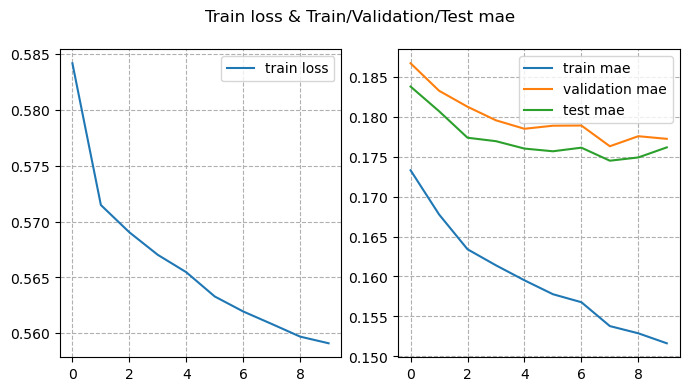

In [16]:
from matplotlib import pyplot as plt
metric_values = np.array(metric_values)
loss_values = [x[1] for x in loss_values]
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(loss_values, label="train loss")
ax[0].legend()
ax[0].grid(linestyle="--",which="major")

ax[1].plot(metric_values[:, 1], label="train mae")
ax[1].plot(metric_values[:, 2], label="validation mae")
ax[1].plot(metric_values[:, 3], label="test mae")
ax[1].legend()
ax[1].grid(linestyle="--",which="major")
plt.suptitle("Train loss & Train/Validation/Test mae")
plt.show()